In [1]:
import numpy as np
import scipy
from scipy.interpolate import griddata
import pandas as pd
import math
import matplotlib
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import dataloader as dl
import bandpower

## Plot head

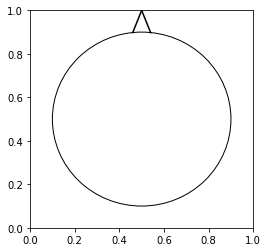

In [118]:
fig, ax = plt.subplots(figsize=(4,4))

radius = 0.4
height = (radius**2-0.04**2)**0.5

ax.set_xlim((0, 1))
ax.set_ylim((0, 1))

# nose
ax.plot([0.46,0.5], [0.5+height,1], color='black')
ax.plot([0.5,0.54], [1,0.5+height], color='black')

# head
head = plt.Circle((0.5,0.5), radius, color='black', fill=False)
ax.add_artist(head)


## Read channel info

In [2]:
# Get list of data names
df_names = pd.read_csv('./Data_Matlab/data_list.csv')
data_names = [x[0:6] for x in df_names.values.flatten()]

# Read data
date = 0
X, Y, C = dl.read_data([1,2,3], date)
powers = bandpower.get_bandpower(X)
num_example = powers.shape[0]

# Read channel locations
channel_info = pd.read_csv('./Channel_coordinate/%s_channels.csv'%(data_names[date]))
channel_info = channel_info.to_numpy()
num_channels = channel_info.shape[0]

# Remove channels whose arc_length>0.5
chosen_channels = np.where(channel_info[:,3]<=0.5)[0]
channel_info = channel_info[chosen_channels, :]
powers = powers[:,chosen_channels,:]
print('Remove %d channels'%(num_channels-channel_info.shape[0]))
num_channels = channel_info.shape[0]

# Change coordinate from 0 toward naison to 0 toward right ear
channel_info[:,2] = 90-channel_info[:,2]


Event 1 X shape:  (20, 128, 512)
Event 2 X shape:  (33, 128, 512)
Event 3 X shape:  (12, 128, 512)
Combined X shape:  (65, 128, 512)
After removing outliers, X shape:  (63, 128, 512)
Calculating the bandpower of time-series data...
Remove 18 channels


In [6]:
Y.shape

(65,)

## Plot topoplot

In [3]:
band_name = ['theta', 'alpha', 'beta']
cmap_name = ['Reds', 'Greens', 'Blues']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


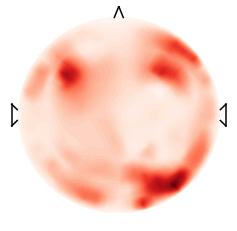

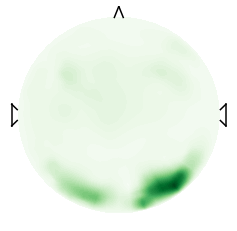

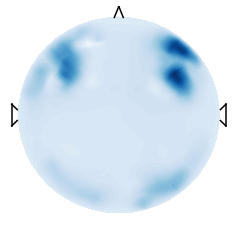

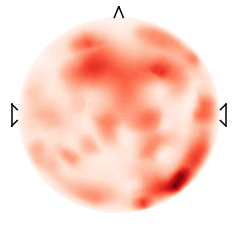

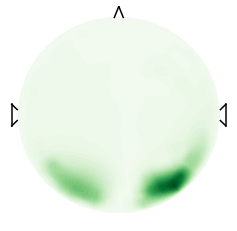

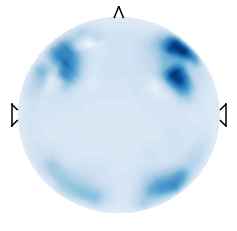

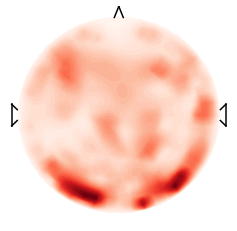

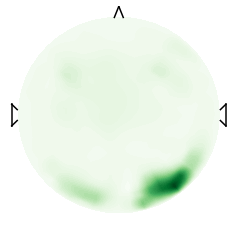

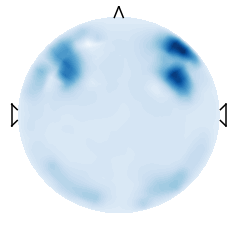

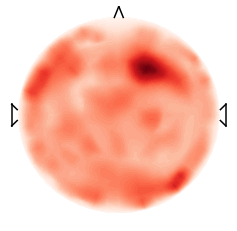

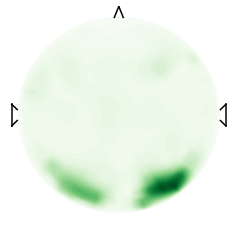

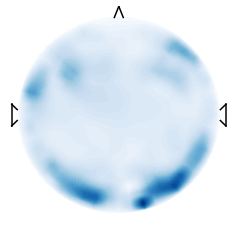

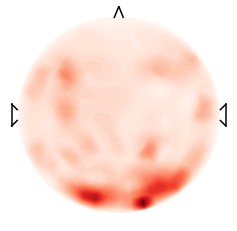

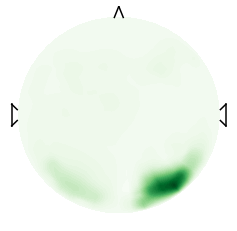

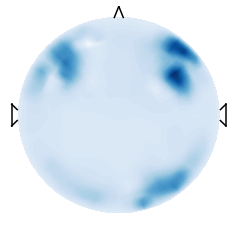

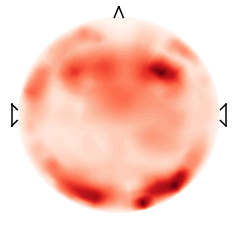

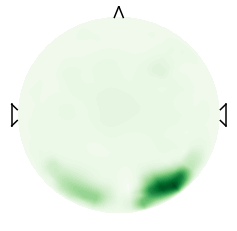

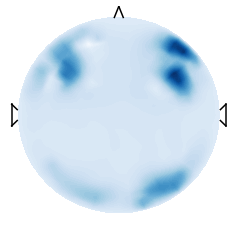

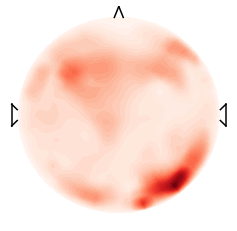

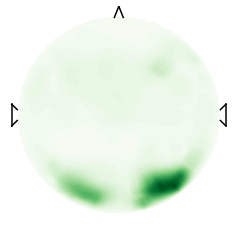

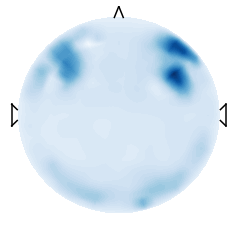

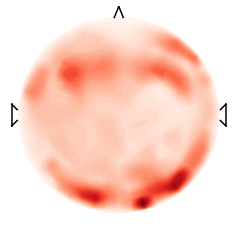

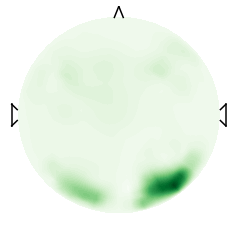

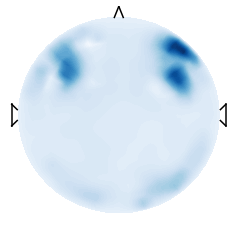

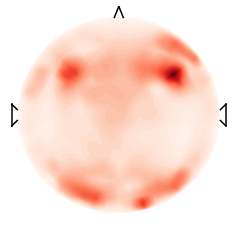

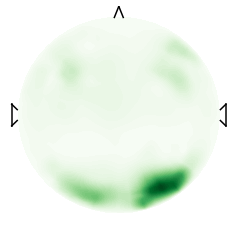

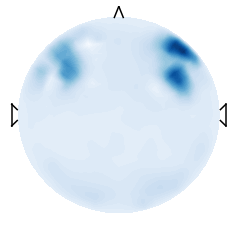

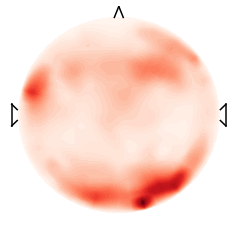

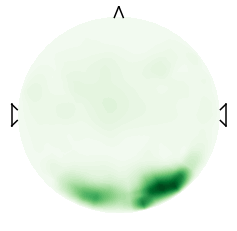

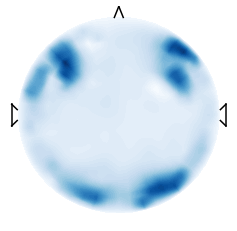

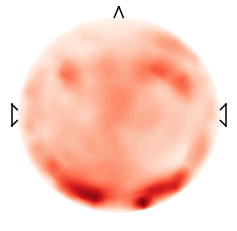

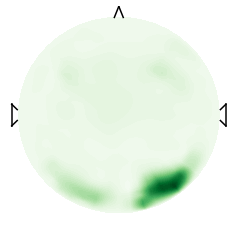

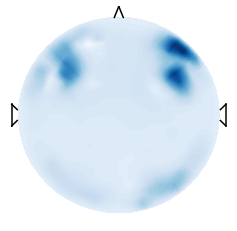

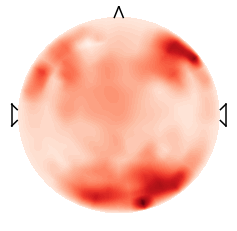

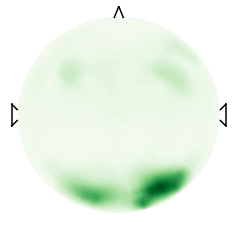

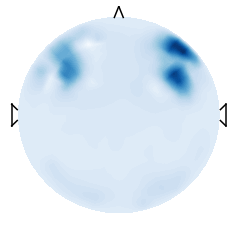

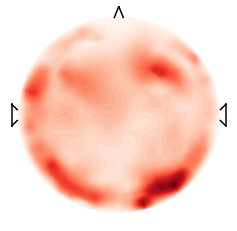

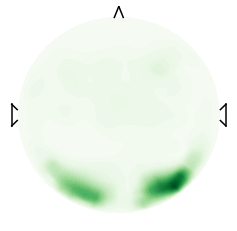

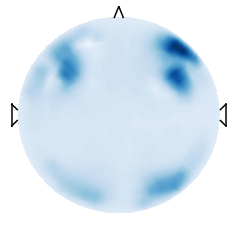

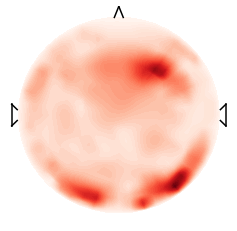

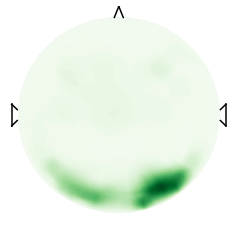

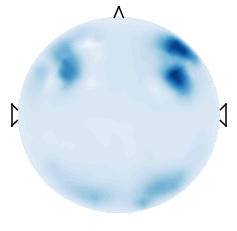

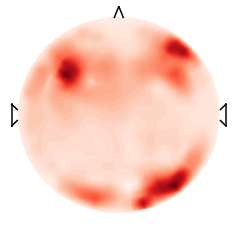

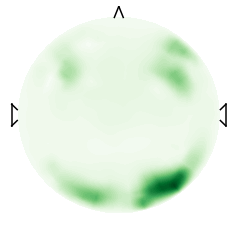

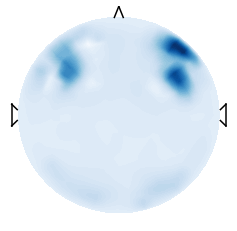

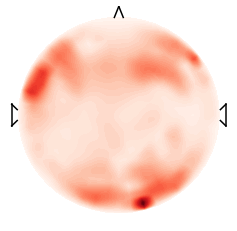

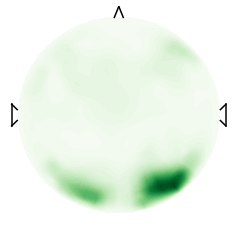

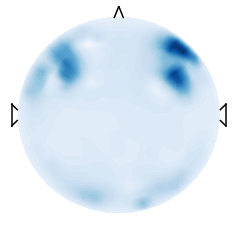

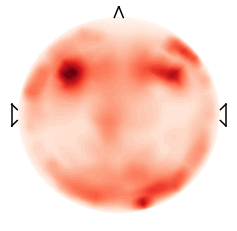

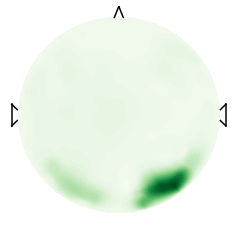

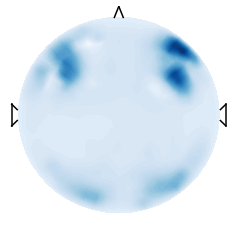

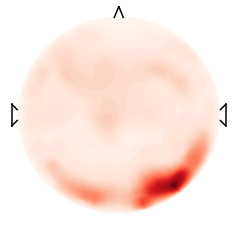

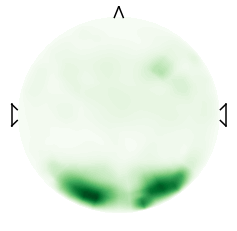

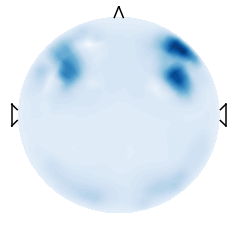

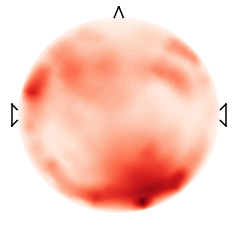

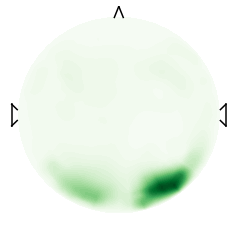

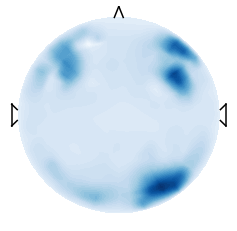

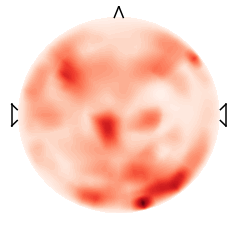

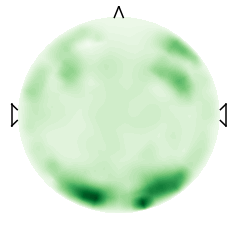

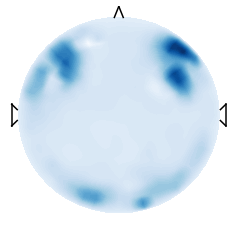

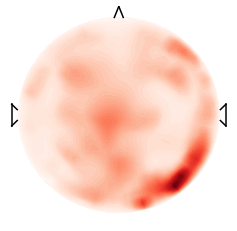

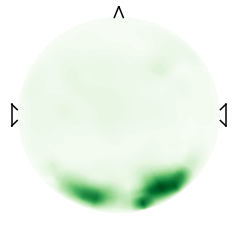

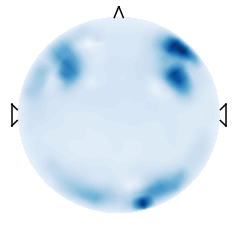

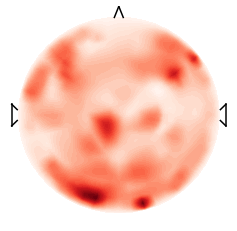

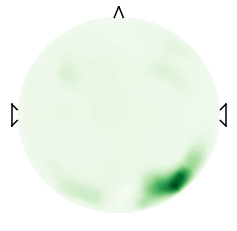

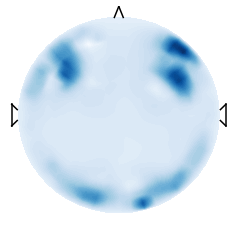

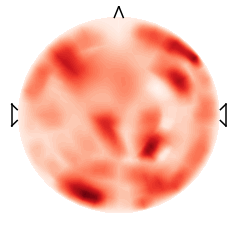

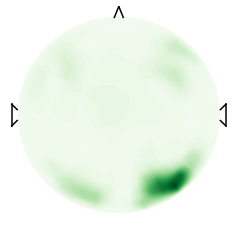

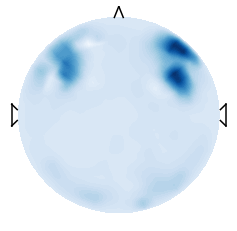

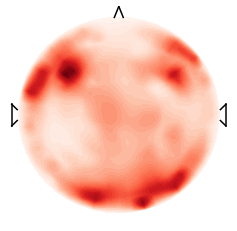

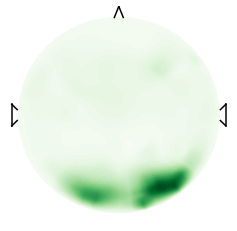

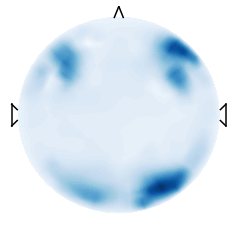

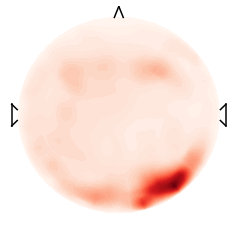

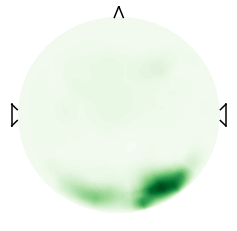

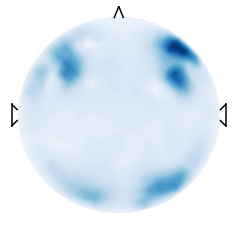

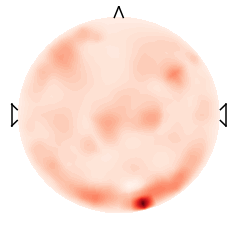

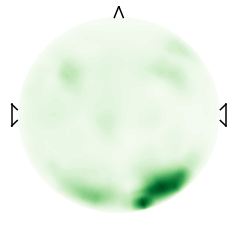

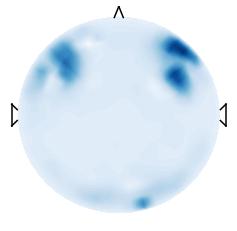

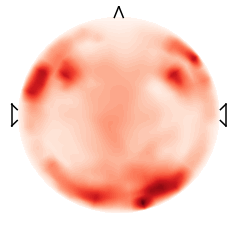

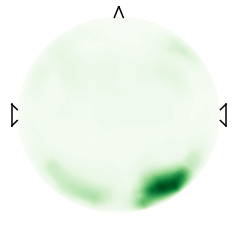

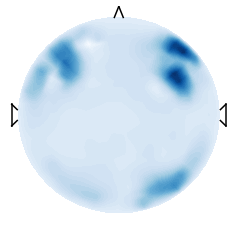

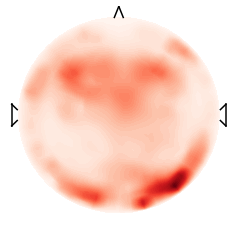

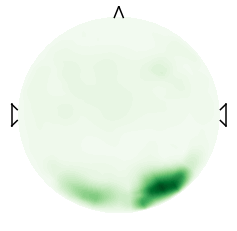

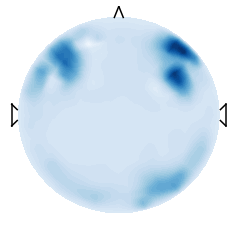

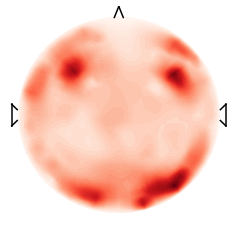

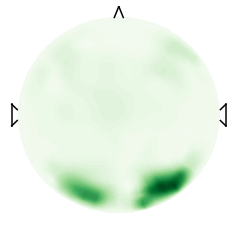

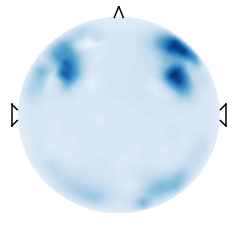

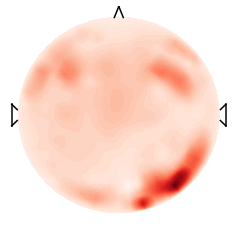

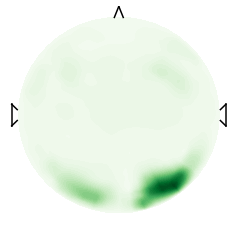

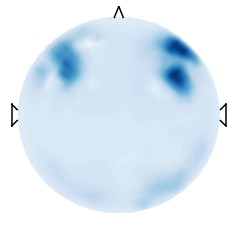

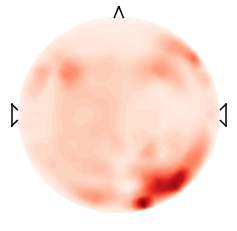

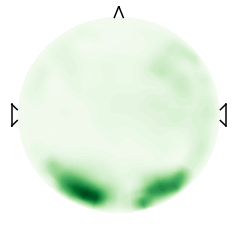

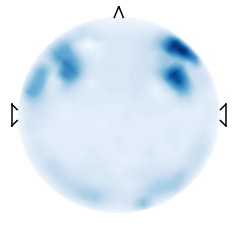

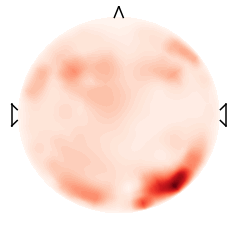

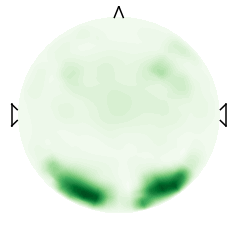

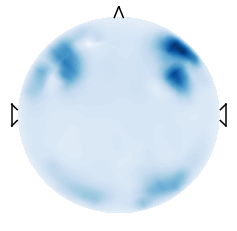

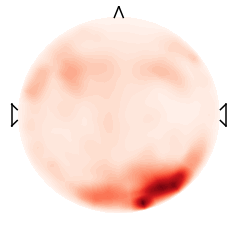

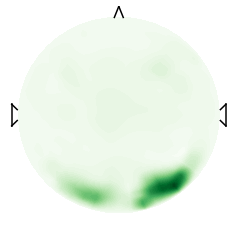

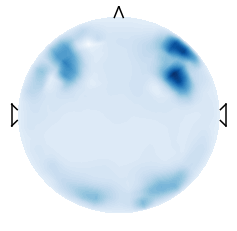

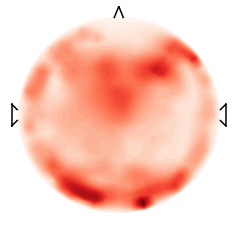

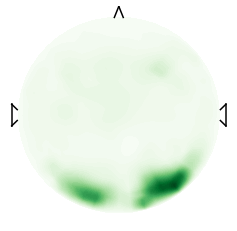

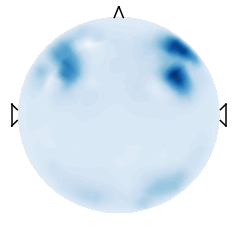

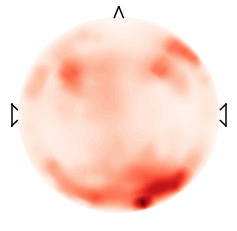

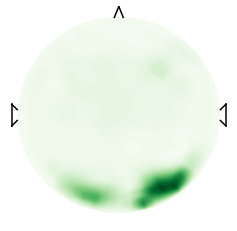

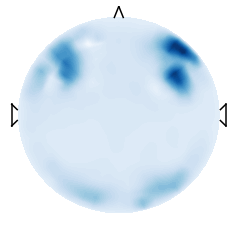

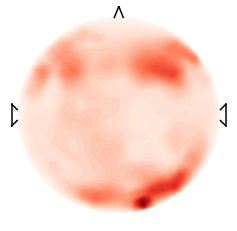

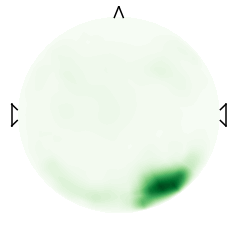

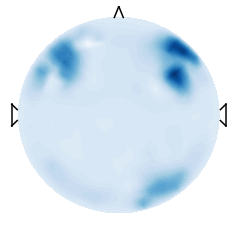

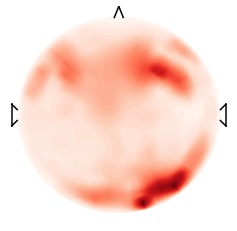

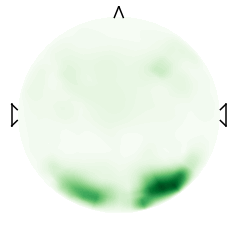

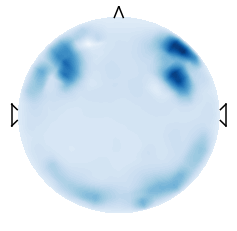

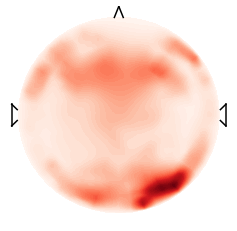

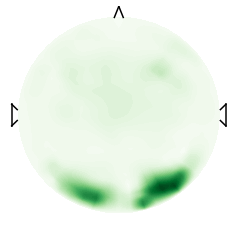

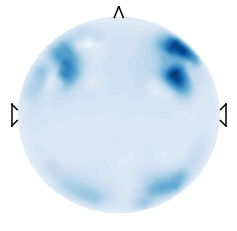

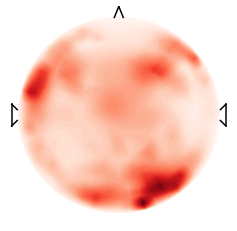

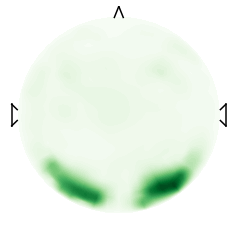

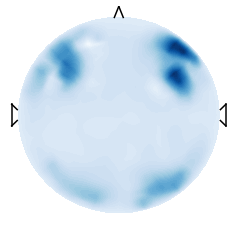

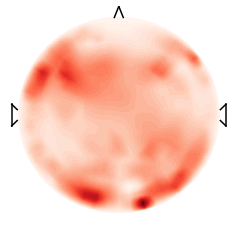

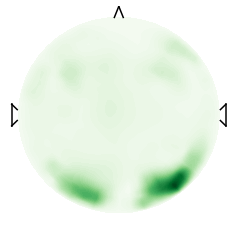

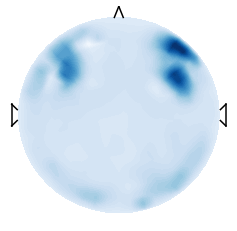

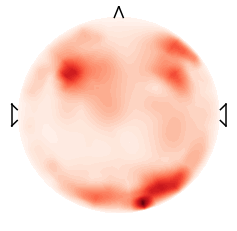

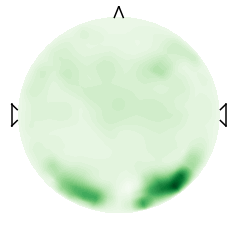

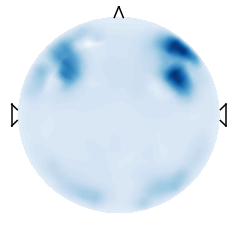

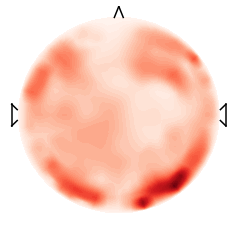

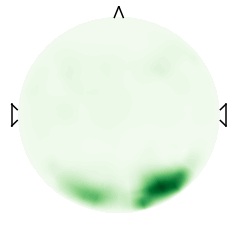

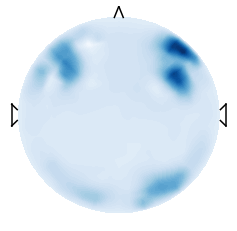

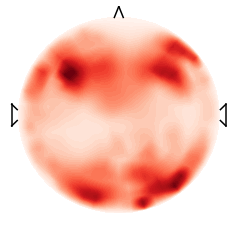

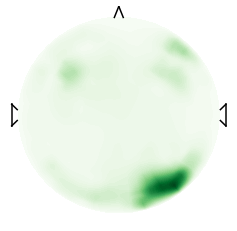

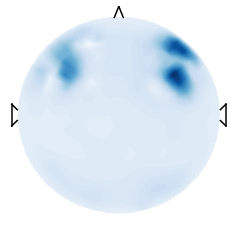

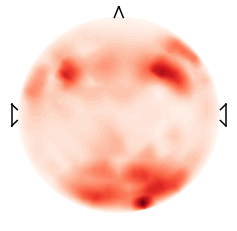

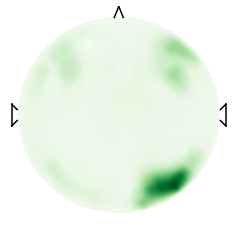

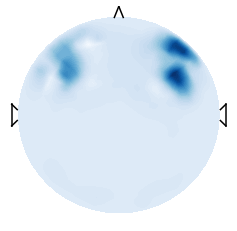

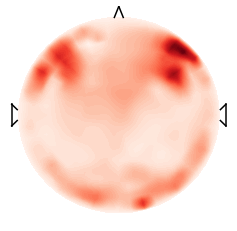

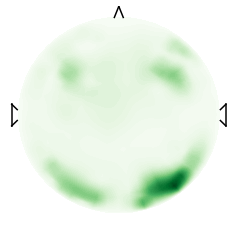

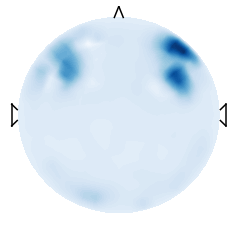

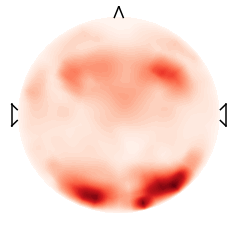

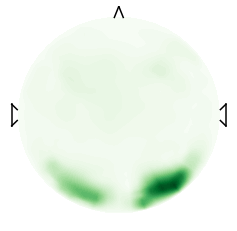

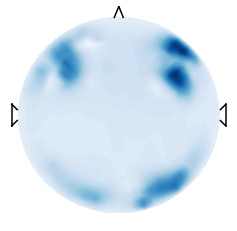

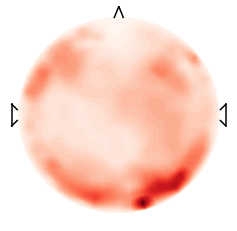

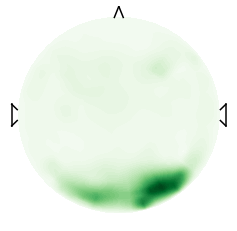

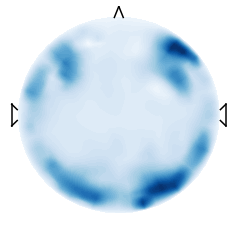

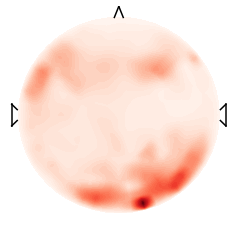

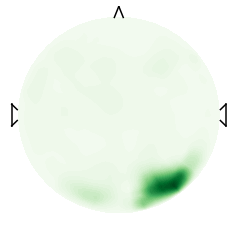

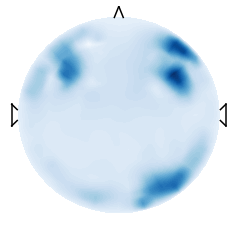

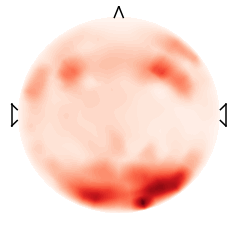

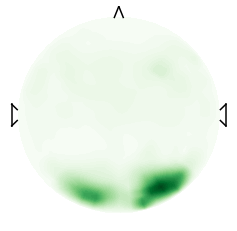

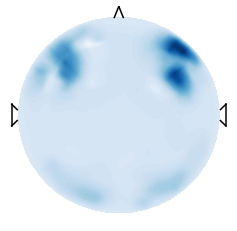

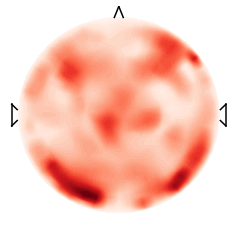

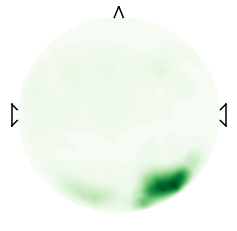

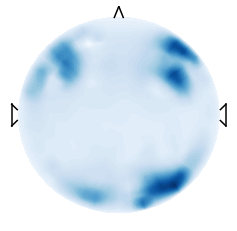

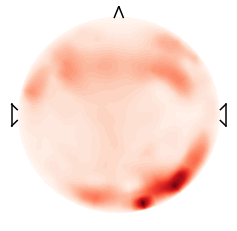

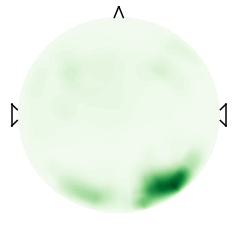

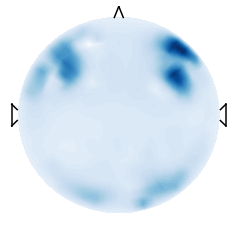

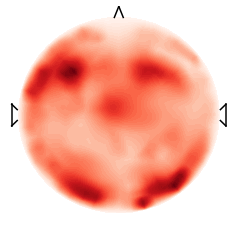

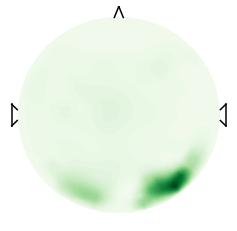

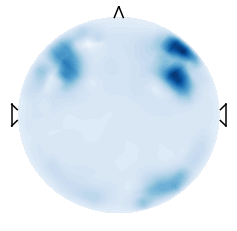

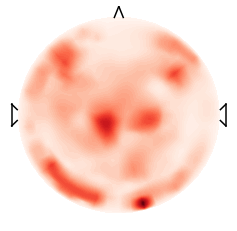

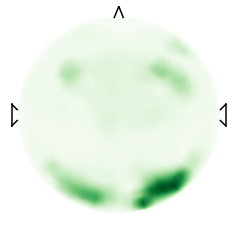

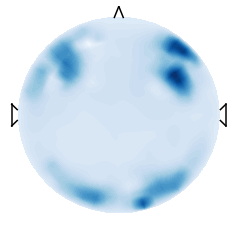

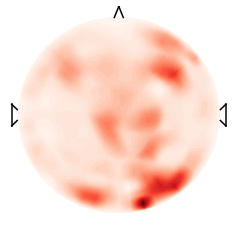

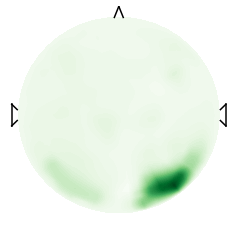

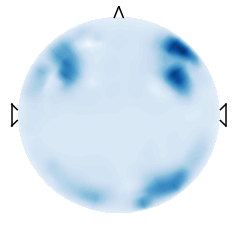

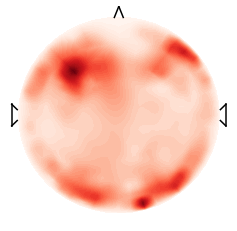

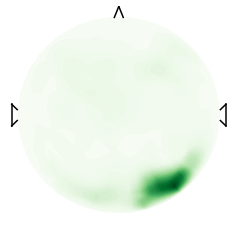

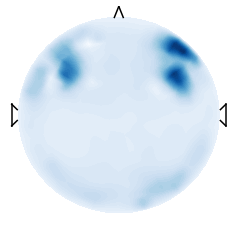

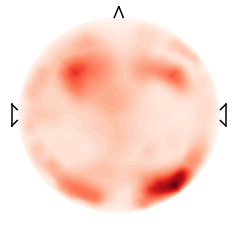

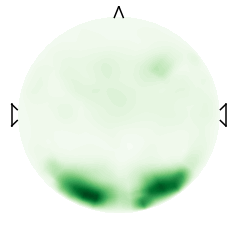

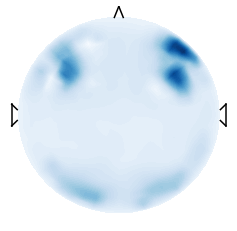

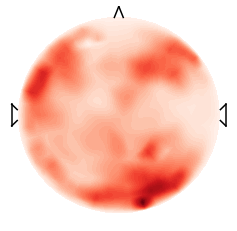

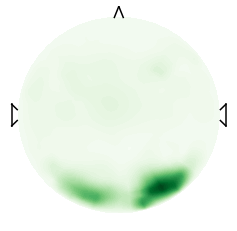

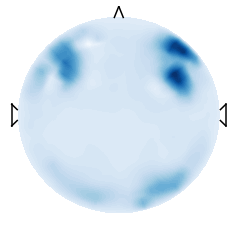

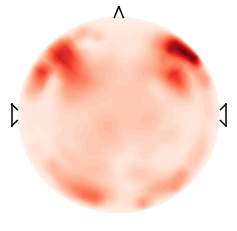

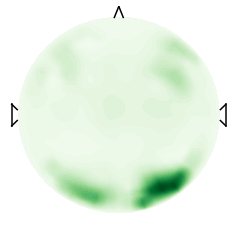

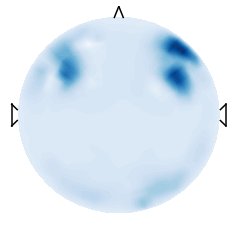

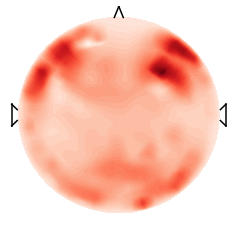

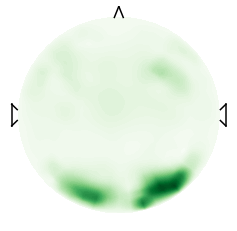

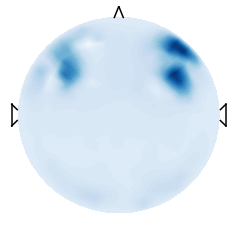

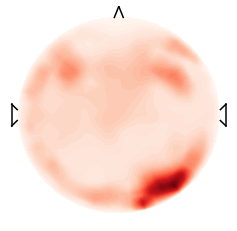

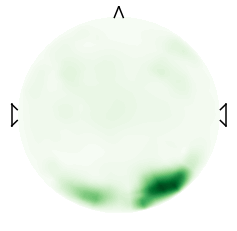

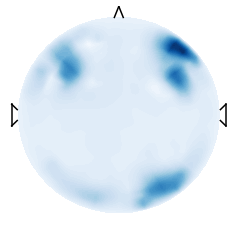

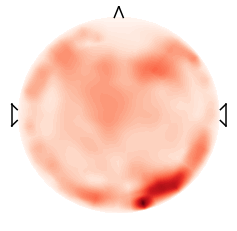

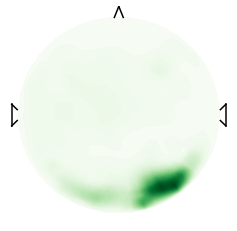

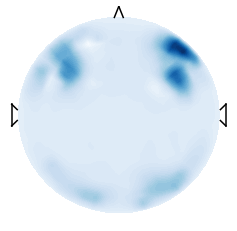

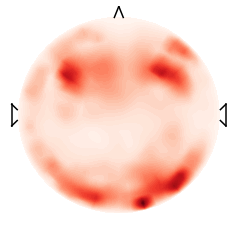

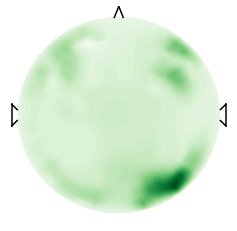

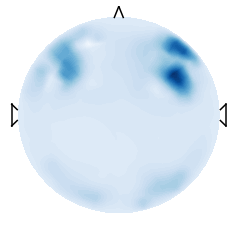

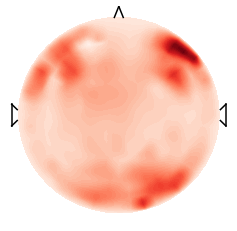

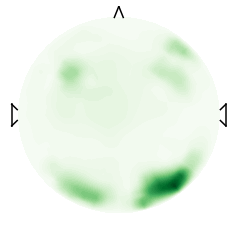

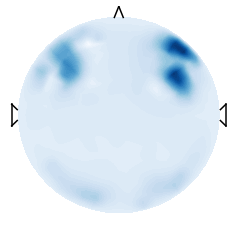

In [4]:
for i_data in range(num_example):
    
    for i_band in range(3):
        fig, ax = plt.subplots(figsize=(4,4))
        n_angles = 48
        n_radii = 1000
        radius = 0.9
        radii = np.linspace(0, radius, n_radii)
        angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)

        # Calculate channel locations on the plot
        scale_radius = radius/0.5
        scale_arc = scale_radius*channel_info[:,3]
        plot_loc = np.zeros((num_channels, 2)) # first for x, second for y
        plot_loc[:,0] = scale_arc*np.cos(np.array(channel_info[:,2]*np.pi/180, dtype = np.float))
        plot_loc[:,1] = scale_arc*np.sin(np.array(channel_info[:,2]*np.pi/180, dtype = np.float))


        # Add couple of zeros to outline for interpolation
        add_x = np.reshape(radius*np.cos(angles), (len(angles), 1))
        add_y = np.reshape(radius*np.sin(angles), (len(angles), 1))
        add_element = np.concatenate((add_x, add_y), axis=1)
        plot_loc = np.concatenate((plot_loc, add_element), axis=0)
        channel_values = np.concatenate((powers[i_data,:,i_band], np.zeros(len(angles))))

        # Interpolate 
        angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1) 
        x = (radii * np.cos(angles)).flatten()
        y = (radii * np.sin(angles)).flatten()
        z = griddata(plot_loc, channel_values, (x, y), method = 'cubic', fill_value=0, rescale=True)

        triang = tri.Triangulation(x, y)

        ax.set_xlim((-1, 1))
        ax.set_ylim((-1, 1))
        tcf = ax.tricontourf(triang, z, cmap = cmap_name[i_band], levels=50)   # Reds, Greens, Blues
        #fig.colorbar(tcf)

        # Add nose
        radius = 0.4   # radius on the plot
        height = (radius**2-0.04**2)**0.5
        ax.plot([-0.04,0], [0.5+height,1], color='black')
        ax.plot([0,0.04], [1,0.5+height], color='black')

        # Add ears
        ax.plot([-0.91,-0.96], [0.05, 0.1], color='black')
        ax.plot([-0.96,-0.96], [0.1, -0.1], color='black')
        ax.plot([-0.96,-0.91], [-0.1, -0.05], color='black')
        ax.plot([0.91,0.96], [0.05, 0.1], color='black')
        ax.plot([0.96,0.96], [0.1, -0.1], color='black')
        ax.plot([0.96,0.91], [-0.1, -0.05], color='black')

        ax.axis('off')
        plt.savefig('./images/%s_%d_%s.png'%(data_names[date], i_data, band_name[i_band]))


## Combine three plots

In [6]:
fileNames = np.empty(num_example, dtype=object)
for i_data in range(num_example):
    figure_r = plt.imread('./images/%s_%d_%s.png'%(data_names[date], i_data, band_name[0]))
    figure_g = plt.imread('./images/%s_%d_%s.png'%(data_names[date], i_data, band_name[1]))
    figure_b = plt.imread('./images/%s_%d_%s.png'%(data_names[date], i_data, band_name[2]))

    figure_mix = (figure_r+figure_g+figure_b)/3
    fileName = '%s_%d_mix'%(data_names[date], i_data)
    plt.imsave('./images/%s.png'%(fileName), figure_mix)
    
    fileNames[i_data] = fileName
    
# Split for training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(fileNames, Y, test_size=0.1, random_state=42)

# Save csv for dataloader
X_train_df = pd.DataFrame({'fileName':X_train})
X_train_df.to_csv('./images/train_img.csv')

X_test_df = pd.DataFrame({'fileName':X_test})
X_test_df.to_csv('./images/test_img.csv')

Y_train_df = pd.DataFrame({'solution_time':Y_train})
Y_train_df.to_csv('./images/train_label.csv')

Y_test_df = pd.DataFrame({'solution_time':Y_test})
Y_test_df.to_csv('./images/test_label.csv')


## Tricontour demo of https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/tricontour_demo.html#sphx-glr-gallery-images-contours-and-fields-tricontour-demo-py

In [56]:
# First create the x and y coordinates of the points.
n_angles = 48
n_radii = 8
min_radius = 0
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += np.pi / n_angles

x = (radii * np.cos(angles)).flatten()
y = (radii * np.sin(angles)).flatten()
z = (np.cos(radii) * np.cos(3 * angles)).flatten()
z = np.multiply(np.square(x), np.square(y))

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(x, y)

# Mask off unwanted triangles.
triang.set_mask(np.hypot(x[triang.triangles].mean(axis=1),
                         y[triang.triangles].mean(axis=1))
                < min_radius)

Text(0.5, 1.0, 'Contour plot of Delaunay triangulation')

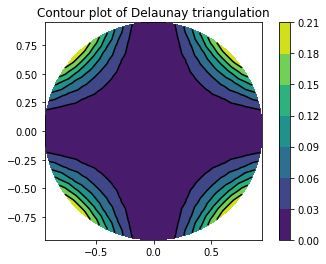

In [57]:
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
tcf = ax1.tricontourf(triang, z)
fig1.colorbar(tcf)
ax1.tricontour(triang, z, colors='k')
ax1.set_title('Contour plot of Delaunay triangulation')